## Analyse indiviudal events in Cape Verde

In [1]:
import numpy as np 
import matplotlib.pyplot as pyplot
import xarray as xr
import matplotlib.pyplot as plt
import scipy.signal as sig

In [2]:
import dask, dask_jobqueue 
import dask.distributed as dask_distributed

cluster = dask_jobqueue.SLURMCluster(
        # Dask worker size
        cores=32, memory='80GB',
        processes=4, # Dask workers per job
       # SLURM job script things
        queue='base', walltime='03:00:00',
        # Dask worker network and temporary
        interface='ib0', local_directory='./dask_jobqueue_logs'
        )

client = dask_distributed.Client(cluster)
cluster.scale(jobs=1)


/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35285 instead
  warnings.warn(


In [9]:
!squeue -u smomw379

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          17347135      base dask-wor smomw379  R       0:07      1 nesh-clk501


In [10]:
client

<Client: 'tcp://172.18.4.21:40461' processes=4 threads=32, memory=74.52 GiB>

## MHW mask

In [11]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'

MHW_WMO = np.zeros((15706, 46))

for zz in range(0,46):
    if zz<10:
        zr=f'0{zz}'
        MHW_WMO[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-WMO-{zr}.nc').mhw_mask
    else:
        MHW_WMO[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-WMO-{zz}.nc').mhw_mask

In [12]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'

MHW_detrend = np.zeros((15706, 46))

for zz in range(0,46):
    if zz<10:
        zr=f'0{zz}'
        MHW_detrend[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-{zr}.nc').mhw_mask
    else:
        MHW_detrend[:,zz] = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-{zz}.nc').mhw_mask

## Climatology function

In [13]:
def daily_clim(temp, doy): 

    ## for each day of the year get list of indices from full timeseries 
    doys = np.arange(doy-5,doy+6) # Hobday et al. (2016): take +- 5 days

    doys[doys<1]   = 366 + doys[doys<1] # include last/first days of year at beginning/end of year
    doys[doys>366] = doys[doys>366] - 366
    # get the indices in a sorted array
    ind_doy = np.array([])
    for xx in range(0,11):
      ind_doy = np.append(ind_doy, np.where(time_counter.dt.dayofyear == doys[xx])[0])
    ind_doy = np.sort(ind_doy).astype(int)

    ## temperature at doy from all years
    T_doy = temp.sel(time_counter=tsel).isel(time_counter=ind_doy)
    if doy==0:
      print(T_doy.time_counter[[0,-1]].values)

    ## average temperature for doy
    T_clim = T_doy.mean('time_counter').compute()

    ## standard deviation temperature for doy
    T_std = T_doy.std('time_counter').compute()

    return T_clim, T_std

## Heat content

### fixed baseline

In [14]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHC = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHC_CapeVerde.nc', chunks={'time_counter':1}).load()

tsel = slice('1980','2009') # baseline period
time_counter = dsOHC.time_counter.sel(time_counter=tsel)
dpt = dsOHC.deptht

In [15]:
OHC_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHC_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

for doy in range(0,366):
    OHC_clim[doy,:], OHC_std[doy,:] = daily_clim(dsOHC.OHC, doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']


In [16]:
## anomaly from daily climatology
OHC_ano = np.zeros((15706,46)); 
tc=0

for yr in range(1980,2022+1):
    OHC_yr = dsOHC.OHC.groupby('time_counter.year')[yr]

    if len(OHC_yr)==366:
    
        OHC_ano[tc:tc+366,:] =  (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHC_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHC_ano[tc:tc+365,:] = (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHC_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHC_ano = xr.DataArray(OHC_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

In [17]:
# calculate heat content change
dOHC_ano = OHC_ano.differentiate('time_counter')/(24*3600)

dOHC = dsOHC.OHC.drop('time_counter').differentiate('time_counter')/(24*3600)

/tmp/ipykernel_218913/4217206456.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  dOHC = dsOHC.OHC.drop('time_counter').differentiate('time_counter')/(24*3600)


### detrended baseline

In [18]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHC = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHC_CapeVerde.nc', chunks={'time_counter':1}).load()
OHC_detr = xr.DataArray(sig.detrend(dsOHC.OHC, axis=0)).rename({'dim_0':'time_counter','dim_1':'deptht'}).assign_coords({'time_counter':dsOHC.time_counter, 'deptht':dpt})

tsel = slice('1980','2022') # baseline period
time_counter = dsOHC.time_counter.sel(time_counter=tsel)
dpt = dsOHC.deptht

In [19]:
OHCd_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHCd_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

for doy in range(0,366):
    OHCd_clim[doy,:], OHCd_std[doy,:] = daily_clim(OHC_detr, doy)

['1980-01-01T12:00:00.000000000' '2022-12-31T12:00:00.000000000']


In [20]:
## anomaly from daily climatology
OHCd_ano = np.zeros((15706,46)); 
tc=0

for yr in range(1980,2022+1):
    OHC_yr = OHC_detr.groupby('time_counter.year')[yr]

    if len(OHC_yr)==366:
    
        OHCd_ano[tc:tc+366,:] =  (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHCd_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHCd_ano[tc:tc+365,:] = (OHC_yr.groupby('time_counter.dayofyear') 
                                     - OHCd_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHCd_ano = xr.DataArray(OHCd_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

## Heat budget term profiles 

In [21]:
yCV = range(1002,1107)
xCV = range(1447,1532)

## Surface heat flux

In [22]:
path ='/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc'
dsM = xr.open_dataset(path).squeeze().rename({'z':'deptht'}).isel(x=xCV, y=yCV)

## grid cell area
A = (dsM.e1t * dsM.e2t).where(dsM.tmask==1).compute()

In [23]:
calc_HFX = False

if calc_HFX:
    path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-6th/nemo/output/1d_compressed/'
    HFX_mn = np.zeros((15706))

    tc=0
    for yr in range(1980,2023):
        dsT = xr.open_dataset(path + f'1_VIKING20X.L46-KFS003-6th_1d_{yr}0101_{yr}1231_grid_T.nc').isel(x=xCV_N,y=yCV_N)

        ## heat flux integrated over the area
        lt = len(dsT.time_counter)
        HFX = dsT.sohefldo
        HFX_mn[tc:tc+lt] = (HFX * dsM.e1t * dsM.e2t).sum(('x','y')).compute()
        tc+=lt

        print(yr, end=' ')

    ## save output
    HFX_mn = xr.DataArray(HFX_mn).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})
    ds_out = xr.Dataset(data_vars = {'HFX_mn':HFX_mn})
    ds_out.to_netcdf('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_HFX-CapeVerde.nc')
else:
    ## load integrated heat flux if it exists
    dsHFX = xr.open_dataset('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_HFX-CapeVerde.nc')


In [24]:
HFX_clim = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
HFX_std  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

tsel = slice('1980','2009')
time_counter = dsHFX.time_counter.sel(time_counter=tsel)

for doy in range(0,366):
    HFX_clim[doy], HFX_std[doy] = daily_clim(dsHFX.HFX_mn.sel(time_counter=tsel), doy)


HFXd_clim = xr.DataArray(np.zeros((366))).rename('seas').rename({'dim_0':'doy'})
HFXd_std  = xr.DataArray(np.zeros((366))).rename('std').rename({'dim_0':'doy'})

tsel = slice('1980','2022')
time_counter = dsHFX.time_counter.sel(time_counter=tsel)

for doy in range(0,366):
    HFXd_clim[doy], HFXd_std[doy] = daily_clim(dsHFX.HFX_mn.sel(time_counter=tsel), doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']
['1980-01-01T12:00:00.000000000' '2022-12-31T12:00:00.000000000']


In [25]:
## calculate anomaly from daily climatology
time_counter = dsHFX.time_counter

HFX_ano = np.array([]); HFXd_ano = np.array([]); 

for yr in range(1980,2022+1):
    HFX_yr = dsHFX.HFX_mn.groupby('time_counter.year')[yr]

    ## keep the mean heat flux
    if len(HFX_yr)==366:
    
        HFX_ano = np.append(HFX_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFX_clim.rename({'doy':'dayofyear'})).compute())
        HFXd_ano = np.append(HFXd_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFXd_clim.rename({'doy':'dayofyear'})).compute())
        
    else:
        HFX_ano = np.append(HFX_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFX_clim[0:-1].rename({'doy':'dayofyear'})).compute())
        HFXd_ano = np.append(HFXd_ano, (HFX_yr.groupby('time_counter.dayofyear') 
                                     - HFXd_clim[0:-1].rename({'doy':'dayofyear'})).compute())

HFX_ano = xr.DataArray(HFX_ano).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})
HFX_ano = HFX_ano - HFX_ano.mean('time_counter')

HFXd_ano = xr.DataArray(HFXd_ano).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})
HFXd_ano = HFXd_ano - HFXd_ano.mean('time_counter')

## Ocean heat transport

In [26]:
## load ocean heat transport
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsOHT = xr.open_mfdataset(path+'1_VIKING20X.L46-KFS003-6th_1d_*_OHT-Tref_CapeVerde.nc', chunks={'time_counter':1})

In [27]:
## combine sections
OHT_net = (-dsOHT.OHT_E+dsOHT.OHT_W+dsOHT.OHT_S-dsOHT.OHT_N).compute()

/gxfs_work/geomar/smomw379/miniconda3/envs/py3_mhw/lib/python3.12/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 9.86 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [28]:
## fixed baseline
OHT_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2009')
time_counter = dsOHT.time_counter.sel(time_counter=tsel)
for doy in range(0,366):
    OHT_clim[doy,:], OHT_std[doy,:] = daily_clim(OHT_net, doy)

## detrended baseline
OHTd_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHTd_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2022')
time_counter = dsOHT.time_counter.sel(time_counter=tsel)
for doy in range(0,366):
    OHTd_clim[doy,:], OHTd_std[doy,:] = daily_clim(OHT_net, doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']
['1980-01-01T12:00:00.000000000' '2022-12-31T12:00:00.000000000']


In [29]:
## calculate anomaly from daily climatology
OHT_ano = np.zeros((15706,46)); 
OHTd_ano = np.zeros((15706,46)); 
tc=0

time_counter = dsOHT.time_counter

for yr in range(1980,2022+1):
    OHT_yr = OHT_net.groupby('time_counter.year')[yr]

    if len(OHT_yr)==366:
    
        OHT_ano[tc:tc+366,:] =  (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim.rename({'doy':'dayofyear'})).compute() 
        OHTd_ano[tc:tc+366,:] =  (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHTd_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHT_ano[tc:tc+365,:] = (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHT_clim[0:-1,:].rename({'doy':'dayofyear'})).compute() 
        OHTd_ano[tc:tc+365,:] = (OHT_yr.groupby('time_counter.dayofyear') 
                                     - OHTd_clim[0:-1,:].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHT_ano = xr.DataArray(OHT_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})
OHT_ano = OHT_ano - OHT_ano.mean('time_counter')

OHTd_ano = xr.DataArray(OHTd_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'}).assign_coords({'time_counter':time_counter})
OHTd_ano = OHTd_ano - OHTd_ano.mean('time_counter')

## vertical heat transport

In [30]:
path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'
dsWT = xr.open_mfdataset(path + f'1_VIKING20X.L46-KFS003-6th_1d_*_OHT-Tref-Vert_CapeVerde.nc')

In [31]:
## fixed baseline
OHT_Vert_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHT_Vert_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2009')
time_counter = dsWT.time_counter.sel(time_counter=tsel)

for doy in range(0,366):
    OHT_Vert_clim[doy,:], OHT_Vert_std[doy,:] = daily_clim(dsWT.OHT_vert, doy)


## detrended baseline
OHTd_Vert_clim = xr.DataArray(np.zeros((366,46))).rename('seas').rename({'dim_0':'doy', 'dim_1':'deptht'})
OHTd_Vert_std  = xr.DataArray(np.zeros((366,46))).rename('std').rename({'dim_0':'doy', 'dim_1':'deptht'})

tsel=slice('1980','2022')
time_counter = dsWT.time_counter.sel(time_counter=tsel)

for doy in range(0,366):
    OHTd_Vert_clim[doy,:], OHTd_Vert_std[doy,:] = daily_clim(dsWT.OHT_vert, doy)

['1980-01-01T12:00:00.000000000' '2009-12-31T12:00:00.000000000']
['1980-01-01T12:00:00.000000000' '2022-12-31T12:00:00.000000000']


In [32]:
## anomaly from daily climatology
OHT_Vert_ano = np.zeros((15706,46)); 
OHTd_Vert_ano = np.zeros((15706,46)); 
tc=0

time_counter = dsWT.time_counter

for yr in range(1980,2022+1):
    OHT_Vert_yr = dsWT.OHT_vert.groupby('time_counter.year')[yr]
    OHT_Vert_yr = OHT_Vert_yr.chunk({'time_counter':len(OHT_Vert_yr.time_counter)})

    if len(OHT_Vert_yr)==366:
    
        OHT_Vert_ano[tc:tc+366,:] =  (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim.rename({'doy':'dayofyear'})).compute() 

        OHTd_Vert_ano[tc:tc+366,:] =  (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHTd_Vert_clim.rename({'doy':'dayofyear'})).compute() 
        tc+=366
    else:
        OHT_Vert_ano[tc:tc+365,:] = (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHT_Vert_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        OHTd_Vert_ano[tc:tc+365,:] = (OHT_Vert_yr.groupby('time_counter.dayofyear') 
                                     - OHTd_Vert_clim[0:-1].rename({'doy':'dayofyear'})).compute() 
        tc+=365

OHT_Vert_ano = xr.DataArray(OHT_Vert_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})
OHTd_Vert_ano = xr.DataArray(OHTd_Vert_ano).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

# remove mean flux
OHT_Vert_ano = OHT_Vert_ano - OHT_Vert_ano.mean('time_counter')
OHTd_Vert_ano = OHTd_Vert_ano - OHTd_Vert_ano.mean('time_counter')

## Derive contribution to MHW events

In [33]:
def derive_event_contributions(event, z, days_b=2, OHC_ano=OHC_ano, OHT_ano=OHT_ano, HFX_ano=HFX_ano, OHT_Vert_ano=OHT_Vert_ano):

    ## timestep of event start
    ind  = np.where(dsOHC.time_counter==ds.time_start[event])[0][0]
    ind_peak  = np.where(dsOHC.time_counter==ds.time_peak[event])[0][0]

    ##  use fixed days prior to event and integrate to peak of event
    if ind<days_b:
        min_max = [ind, ind_peak] # if event is in beginning of timeseries use first day of event to peak
    else:
        min_max = [ind-days_b, ind_peak]

    ## reset all timeseries to start at zero
    offset_OHT = OHT_ano.isel(deptht=z,time_counter=min_max[0])*24*3600 
    offset_Vert = OHT_Vert_ano.isel(deptht=z,time_counter=min_max[0])*24*3600 
    offset_OHC = OHC_ano.isel(deptht=z, time_counter=min_max[0])

    if z==0:
        offset_HFX = HFX_ano.isel(time_counter=min_max[0])*24*3600 


    ## cumulative fluxes and residual
    OHT_event = -offset_OHT + (OHT_ano.isel(deptht=z,time_counter=range(min_max[0],min_max[1]))*24*3600).cumsum()
    Vert_event = -offset_Vert + (OHT_Vert_ano.isel(deptht=z,time_counter=range(min_max[0],min_max[1]))*24*3600).cumsum()

    if z==0:
        HFX_event = -offset_HFX + (HFX_ano.isel(time_counter=range(min_max[0],min_max[1]))*24*3600).cumsum()
        Res_event = OHC_ano.isel(deptht=z, time_counter=range(min_max[0],min_max[1])) - (OHT_event+HFX_event+Vert_event)
        Res_event = Res_event -  Res_event[0].values
    else:
        Res_event = OHC_ano.isel(deptht=z, time_counter=range(min_max[0],min_max[1])) - (OHT_event+Vert_event)
        Res_event = Res_event -  Res_event[0].values    

    ## Heat content evolution
    OHC_event = OHC_ano.isel(deptht=z, time_counter=range(min_max[0], min_max[1])) - offset_OHC

    ## contribution of different fluxes
    if z==0:
        HFX_contr = (HFX_event[-1]+Res_event[-1]) / OHC_event[-1] * 100
    OHT_contr = OHT_event[-1] / OHC_event[-1] * 100
    Vert_contr = Vert_event[-1] / OHC_event[-1] * 100
    Res_contr = Res_event[-1] / OHC_event[-1] * 100

    ## in rare cases the anomaly associated with a MHW can be very small and the decomposition is not meaningful
    #if (OHC_event[-1] - OHC_event[0]) < 1e16:
    #    OHT_contr=np.nan; Vert_contr=np.nan; Res_contr=np.nan; HFX_contr=np.nan
    #    print(f'Anomaly too small for event {event}, delete event')
    if (np.abs(OHT_contr) > 500) or (np.abs(Vert_contr) > 500):
        OHT_contr=np.nan; Vert_contr=np.nan; Res_contr=np.nan; HFX_contr=np.nan
        print(f'Anomaly too small for event {event}, delete event') 

    if z==0:
        return [OHT_contr, Vert_contr, Res_contr, HFX_contr], [OHC_event, OHT_event, Vert_event, Res_event, HFX_event]
    else:
        return [OHT_contr, Vert_contr, Res_contr], [OHC_event, OHT_event, Vert_event, Res_event]

### WMO baseline events

In [34]:
Contributions_profile = np.zeros((46,3))

for z in range(1,46):
    ## load dataset
    path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'

    if z<10: zz=f'0{z}'
    else: zz=str(z)
    ds = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-WMO-{zz}.nc')
    N_events = len(ds.events) # number of events

    ## init arrays
    Contributions = np.zeros((N_events, 3))
    OHT_event = np.zeros((N_events, 3))
    Vert_event = np.zeros((N_events, 3))
    Res_event = np.zeros((N_events, 3))

    ## contribution from different heat budget components
    for event in range(0, N_events):
        Contributions[event,:], _ = derive_event_contributions(event, z)

    ## vertical profile from average over all events
    Contributions_profile[z,:] = np.nanmean(Contributions, axis=0)

    print(z, end='')

## add surface values
ds = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-WMO-00.nc')
N_events = len(ds.events) # number of events 

Contributions_0 = np.zeros((N_events, 4))

for event in range(0, N_events):
    Contributions_0[event,:], _ = derive_event_contributions(event, 0)

Contributions_profile[0,0:2] = np.nanmean(Contributions_0[:,0:2], axis=0)
HFX_contribution = np.nanmean(Contributions_0[:,3], axis=0)

123456789Anomaly too small for event 5, delete event
Anomaly too small for event 10, delete event
1011Anomaly too small for event 21, delete event
1213Anomaly too small for event 1, delete event
14Anomaly too small for event 11, delete event
Anomaly too small for event 24, delete event
1516171819Anomaly too small for event 1, delete event
20Anomaly too small for event 20, delete event
Anomaly too small for event 23, delete event
21Anomaly too small for event 9, delete event
222324252627282930313233Anomaly too small for event 17, delete event
343536Anomaly too small for event 28, delete event
37Anomaly too small for event 33, delete event
3839404142

/tmp/ipykernel_218913/4007581004.py:23: RuntimeWarning: Mean of empty slice
  Contributions_profile[z,:] = np.nanmean(Contributions, axis=0)
/tmp/ipykernel_218913/4007581004.py:23: RuntimeWarning: Mean of empty slice
  Contributions_profile[z,:] = np.nanmean(Contributions, axis=0)
/tmp/ipykernel_218913/4007581004.py:23: RuntimeWarning: Mean of empty slice
  Contributions_profile[z,:] = np.nanmean(Contributions, axis=0)
/tmp/ipykernel_218913/4007581004.py:23: RuntimeWarning: Mean of empty slice
  Contributions_profile[z,:] = np.nanmean(Contributions, axis=0)


434445

### detrended baseline events

In [35]:
Contributions_profile_dtr = np.zeros((46,3))

for z in range(1,46):
    ## load dataset
    path = '/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/'

    if z<10: zz=f'0{z}'
    else: zz=str(z)
    ds = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-{zz}.nc')
    
    N_events = len(ds.events) # number of events
    OHT_event = np.zeros((N_events, 3))
    Vert_event = np.zeros((N_events, 3))
    Res_event = np.zeros((N_events, 3))

    ## init arrays
    Contributions = np.zeros((N_events, 3))

    ## contribution from different heat budget components
    for event in range(0, N_events):
        Contributions[event,:], _ = derive_event_contributions(event, z, OHC_ano=OHCd_ano, OHT_ano=OHTd_ano, HFX_ano=HFXd_ano, OHT_Vert_ano=OHTd_Vert_ano)

    ## vertical profile from average over all events
    Contributions_profile_dtr[z,:] = np.nanmean(Contributions, axis=0)

    print(z, end='')

## add surface values
ds = xr.open_dataset(path+f'1_VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MHWs_CapeVerde-detrend-00.nc')
N_events = len(ds.events) # number of events 

Contributions_0_dtr = np.zeros((N_events, 4))

for event in range(0, N_events):
    Contributions_0_dtr[event,:], _ = derive_event_contributions(event, 0, OHC_ano=OHCd_ano, OHT_ano=OHTd_ano, HFX_ano=HFXd_ano, OHT_Vert_ano=OHTd_Vert_ano)

Contributions_profile_dtr[0,0:2] = np.nanmean(Contributions_0_dtr[:,0:2],axis=0)
HFX_contribution_dtr = np.nanmean(Contributions_0_dtr[:,3],axis=0)

123Anomaly too small for event 20, delete event
Anomaly too small for event 28, delete event
4Anomaly too small for event 19, delete event
56Anomaly too small for event 0, delete event
789101112131415Anomaly too small for event 14, delete event
16Anomaly too small for event 8, delete event
Anomaly too small for event 14, delete event
Anomaly too small for event 16, delete event
171819Anomaly too small for event 22, delete event
20Anomaly too small for event 2, delete event
21222324Anomaly too small for event 1, delete event
25Anomaly too small for event 11, delete event
26Anomaly too small for event 6, delete event
27282930Anomaly too small for event 3, delete event
3132333435Anomaly too small for event 39, delete event
3637383940Anomaly too small for event 20, delete event
Anomaly too small for event 36, delete event
4142

/tmp/ipykernel_218913/2290197836.py:24: RuntimeWarning: Mean of empty slice
  Contributions_profile_dtr[z,:] = np.nanmean(Contributions, axis=0)
/tmp/ipykernel_218913/2290197836.py:24: RuntimeWarning: Mean of empty slice
  Contributions_profile_dtr[z,:] = np.nanmean(Contributions, axis=0)
/tmp/ipykernel_218913/2290197836.py:24: RuntimeWarning: Mean of empty slice
  Contributions_profile_dtr[z,:] = np.nanmean(Contributions, axis=0)


434445

/tmp/ipykernel_218913/2290197836.py:24: RuntimeWarning: Mean of empty slice
  Contributions_profile_dtr[z,:] = np.nanmean(Contributions, axis=0)


## Mixed layer

In [36]:
calc_MLD = False

if calc_MLD:
    path = '/gxfs_work/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003-6th/nemo/output/1d_compressed/'

    MLD_max = np.zeros((15706))
    MLD_mn = np.zeros((15706))

    tc=0
    for yr in range(1980,2023):
        dsT = xr.open_mfdataset(path + f'VIKING20X.L46-KFS003-6th_1d_{yr}0101_{yr}1231_grid_T.nc').isel(x=xCV,y=yCV)

        lt = len(dsT.time_counter)
        MLD = dsT.somxl010.load()
        MLD_max[tc:tc+lt] = MLD.max(('x','y')).compute()
        MLD_mn[tc:tc+lt] = MLD.where(MLD!=0).mean(('x','y')).compute()
        tc+=lt

        print(yr, end=' ')

    MLD_max = xr.DataArray(MLD_max).rename({'dim_0':'time_counter'}).assign_coords({'time_counter':time_counter})
    ds_out = xr.Dataset(data_vars = {'MLD_max':MLD_max})
    ds_out.to_netcdf('VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MLD-CapeVerde.nc')
else:
    dsMLD = xr.open_dataset('/gxfs_work/geomar/smomw379/DATA/VIKING20X.L46-KFS003-6th/CapeVerde/VIKING20X.L46-KFS003-6th_1d_19800101_20221231_MLD-CapeVerde.nc')


## plotting

In [37]:
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

In [38]:
dpt = -dsOHC.deptht

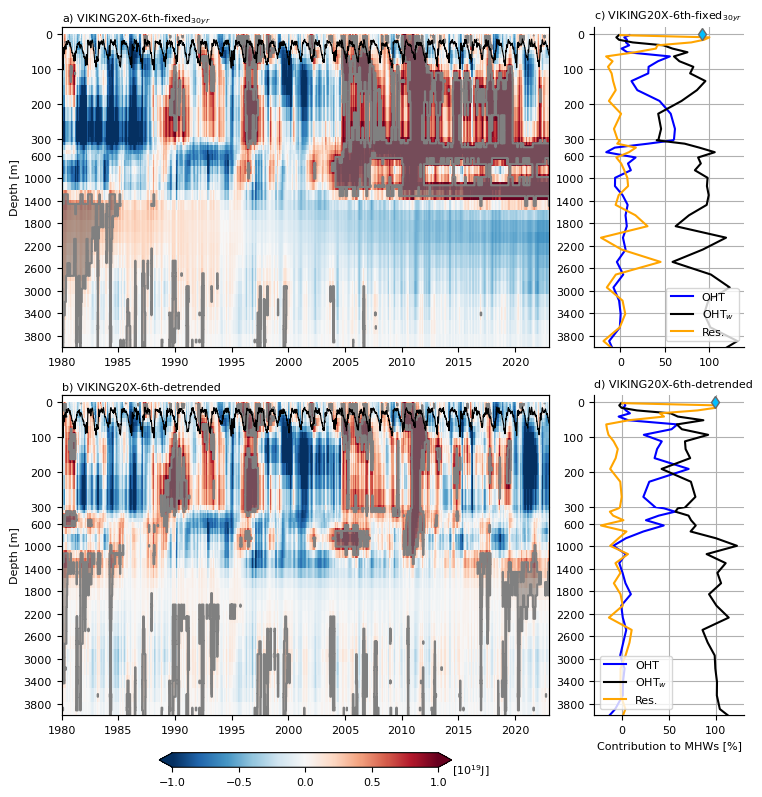

In [35]:
fig = plt.figure(figsize=(7.5,8.))

axB = fig.add_axes([0.79,0.1,0.2,0.4]); axB.spines[['top','right']].set_visible(False); axB.set_yticks([]); axB.set_xticks([]);
axB1 = fig.add_axes([0.79,0.36,0.2,0.14]); axB1.spines[['top','right', 'bottom']].set_visible(False); axB1.set_xticklabels([]);
axB2 = fig.add_axes([0.79,0.1,0.2,0.26]); axB2.spines[['top','right']].set_visible(False); 

axA = fig.add_axes([0.79,0.56,0.2,0.4]); axA.spines[['top','right']].set_visible(False); axA.set_yticks([]); axA.set_xticks([]);
axA1 = fig.add_axes([0.79,0.82,0.2,0.14]); axA1.spines[['top','right','bottom']].set_visible(False);  axA1.set_xticklabels([])
axA2 = fig.add_axes([0.79,0.56,0.2,0.26]); axA2.spines[['top','right']].set_visible(False);

ax1L = fig.add_axes([0.08,0.56,0.65,0.4]); ax1L.set_xticks([]); ax1L.set_yticks([]);
ax1 = fig.add_axes([0.08,0.56,0.65,0.26]); ax1.spines[['top']].set_visible(False); 
ax11 = fig.add_axes([0.08,0.82,0.65,0.14]); ax11.spines[['bottom']].set_visible(False); ax11.set_xticks([])

ax2L = fig.add_axes([0.08,0.1,0.65,0.4]); ax2L.set_xticks([]); ax2L.set_yticks([]);
ax2 = fig.add_axes([0.08,0.1,0.65,0.26]);  ax2.spines[['top']].set_visible(False);
ax21 = fig.add_axes([0.08,0.36,0.65,0.14]); ax21.spines[['bottom']].set_visible(False); ax21.set_xticks([])

axcb = fig.add_axes([0.08,-0.01,0.65,0.42], frameon=False); axcb.set_yticks([]); axcb.set_xticks([])


##
pc = ax1.pcolor(dsOHC.time_counter, dpt, OHC_ano.T/1e19, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.contourf(dsOHC.time_counter, dpt, np.ma.masked_equal(MHW_WMO.T,0), colors='grey', alpha=0.6)
ax1.contour(dsOHC.time_counter, dpt, MHW_WMO.T, colors='grey', levels=[0.9,1])
ax1.set_ylim(-4000,-300)
ax1.set_yticks(np.arange(-3800,-290,400)); ax1.set_yticklabels(np.arange(3800,310,-400))

##
ax11.pcolor(dsOHC.time_counter, dpt, OHC_ano.T/1e19, cmap='RdBu_r', vmin=-1, vmax=1)
ax11.contourf(dsOHC.time_counter, dpt, np.ma.masked_equal(MHW_WMO.T,0), colors='grey', alpha=0.6)
ax11.contour(dsOHC.time_counter, dpt, MHW_WMO.T, colors='grey', levels=[0.9,1])
ax11.plot(time_counter, -dsMLD.MLD_max.rolling({'time_counter':15}, center=True).mean(), 'k', zorder=20, lw=0.8)
ax11.set_ylim(-300,20)
ax11.set_yticks(np.arange(-300,10,100)); ax11.set_yticklabels(np.arange(300,-10,-100))
ax1L.set_ylabel('Depth [m]', fontsize=8, labelpad=30)
ax1L.set_title(r'a) VIKING20X-6th-fixed$_{30yr}$', loc='left', fontsize=8, pad=4)

##
ax2.pcolor(dsOHC.time_counter, dpt, OHCd_ano.T/1e19, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.contourf(dsOHC.time_counter, dpt, np.ma.masked_equal(MHW_detrend.T,0), colors='grey', alpha=0.6)
ax2.contour(dsOHC.time_counter, dpt, MHW_detrend.T, colors='grey', levels=[0.9,1])
ax2.set_ylim(-4000,-300)
ax2.set_yticks(np.arange(-3800,-290,400)); ax2.set_yticklabels(np.arange(3800,310,-400))

##
ax21.pcolor(dsOHC.time_counter, dpt, OHCd_ano.T/1e19, cmap='RdBu_r', vmin=-1, vmax=1)
ax21.contourf(dsOHC.time_counter, dpt, np.ma.masked_equal(MHW_detrend.T,0), colors='grey', alpha=0.6)
ax21.contour(dsOHC.time_counter, dpt, MHW_detrend.T, colors='grey', levels=[0.9,1])
ax21.plot(time_counter, -dsMLD.MLD_max.rolling({'time_counter':15}, center=True).mean(), 'k', zorder=20, lw=0.8)

ax21.set_ylim(-300,20)
ax21.set_yticks(np.arange(-300,10,100)); ax21.set_yticklabels(np.arange(300,-10,-100))
ax2L.set_ylabel('Depth [m]', fontsize=8, labelpad=30)
ax2L.set_title(r'b) VIKING20X-6th-detrended', loc='left', fontsize=8, pad=4)

cb = plt.colorbar(pc, orientation='horizontal', ax=[axcb], shrink=0.6, extend='both')
cb.set_label('[10$^{19}$J]', x=1.12, labelpad=-18, fontsize=8, rotation=0)

##
axA1.plot(Contributions_profile[:,0], dpt, 'b', label='OHT')
axA1.plot(Contributions_profile[:,1], dpt, 'k', label='Vert')
axA1.plot(Contributions_profile[:,2], dpt, 'orange', label='Res')
axA1.plot(HFX_contribution, 0, marker='d', mfc='deepskyblue', mec='dimgrey', ms=6)
axA1.set_yticks(np.arange(-200,10,100)); axA1.set_yticklabels(np.arange(200,-10,-100));
axA1.grid(True)
axA1.set_ylim(-300,20)

axA2.plot(Contributions_profile[:,0], dpt, 'b', label='OHT')
axA2.plot(Contributions_profile[:,1], dpt, 'k', label='OHT$_w$')
axA2.plot(Contributions_profile[:,2], dpt, 'orange', label='Res.')
axA2.set_yticks([-300,-600,-1000,-1400,-1800,-2200,-2600,-3000,-3400,-3800])
axA2.set_yticklabels([300,600,1000,1400,1800,2200,2600,3000,3400,3800])
axA2.grid(True)
axA2.set_ylim(-4000,-300)

axA2.legend(fontsize=8, loc='lower right')
axA.set_title(r'c) VIKING20X-6th-fixed$_{30yr}$', fontsize=8, loc='left')

##
axB1.plot(Contributions_profile_dtr[:,0], dpt, 'b', label='OHT')
axB1.plot(Contributions_profile_dtr[:,1], dpt, 'k', label='OHT$_w$')
axB1.plot(Contributions_profile_dtr[:,2], dpt, 'orange', label='Res.')
axB1.plot(HFX_contribution_dtr, 0, marker='d', mfc='deepskyblue', mec='dimgrey', ms=6)
axB1.set_yticks(np.arange(-200,10,100)); axB1.set_yticklabels(np.arange(200,-10,-100));
axB1.grid(True)
axB1.set_ylim(-300,20)

axB2.plot(Contributions_profile_dtr[:,0], dpt, 'b', label='OHT')
axB2.plot(Contributions_profile_dtr[:,1], dpt, 'k', label='OHT$_w$')
axB2.plot(Contributions_profile_dtr[:,2], dpt, 'orange', label='Res.')
axB2.set_yticks([-300,-600,-1000,-1400,-1800,-2200,-2600,-3000,-3400,-3800])
axB2.set_yticklabels([300,600,1000,1400,1800,2200,2600,3000,3400,3800])
axB2.grid(True)
axB2.set_ylim(-4000,-300)

axB2.legend(fontsize=8, loc='lower left')
axB2.set_xlabel('Contribution to MHWs [%]', fontsize=8)
axB.set_title(r'd) VIKING20X-6th-detrended', fontsize=8, loc='left')

plt.savefig('CapeVerde_HeatBudget.png', dpi=400)

## Save data for publication

In [39]:
MHW_WMO_xr = xr.DataArray(MHW_WMO).rename({'dim_0':'time_counter', 'dim_1':'deptht'})
MHW_detrend_xr = xr.DataArray(MHW_detrend).rename({'dim_0':'time_counter', 'dim_1':'deptht'})

MLD_xr = dsMLD.MLD_max

In [40]:
MHW_WMO_xr.attrs['long_name'] = 'MHW mask for the Cape Verde Archipelago based on fixed 30-year baseline'
MHW_WMO_xr.attrs['units'] = ''

MHW_detrend_xr.attrs['long_name'] = 'MHW mask for the Cape Verde Archipelago based on detrended baseline'
MHW_detrend_xr.attrs['units'] = ''

OHC_ano.attrs['long_name'] = 'Ocean heat content anomaly relative to 30-year fixed baseline in the Cape Verde Archipelago'
OHC_ano.attrs['units'] = 'J'

OHCd_ano.attrs['long_name'] = 'Ocean heat content anomaly relative to detrended baseline in the Cape Verde Archipelago'
OHCd_ano.attrs['units'] = 'J'

MLD_xr.attrs['long_name'] = 'Maximum mixed layer depth in Cape Verde Archipelago'
MLD_xr.attrs['units'] = 'm'

In [41]:
HFXd_xr = xr.DataArray(HFX_contribution_dtr)
HFX_xr = xr.DataArray(HFX_contribution)

Profile_xr = xr.DataArray(Contributions_profile).rename({'dim_0':'deptht', 'dim_1':'BudgetTerm'})
Profile_dtr_xr = xr.DataArray(Contributions_profile_dtr).rename({'dim_0':'deptht', 'dim_1':'BudgetTerm'})

In [42]:
Profile_xr.attrs['long_name'] = 'Contribution of budget terms to MHW events detected with 30-yr fixed baseline'
Profile_xr.attrs['units'] = 'Percent'

Profile_dtr_xr.attrs['long_name'] = 'Contribution of budget terms to MHW events detected with detrended baseline'
Profile_dtr_xr.attrs['units'] = 'Percent'

HFX_xr.attrs['long_name'] = 'Contribution of surface heat flux to MHW events detected with 30-yr fixed baseline'
HFX_xr.attrs['units'] = 'Percent'

HFXd_xr.attrs['long_name'] = 'Contribution of surface heat flux to MHW events detected with detrended baseline'
HFXd_xr.attrs['units'] = 'Percent'

In [43]:
dpt = xr.DataArray(dpt.values).rename({'dim_0':'deptht'})
dpt.attrs['long_name'] = 'Vertical T levels'
dpt.attrs['units'] = 'm'
dpt.attrs['positive'] = 'up'

In [44]:
ds_out = xr.Dataset({'MHW_mask_fixed':MHW_WMO_xr, 'MHW_mask_detrend':MHW_detrend_xr, 'OHC_ano_fixed':OHC_ano,'OHC_ano_detrend':OHCd_ano, 
                     'MLD':MLD_xr, 'HeatFlux_contr_detrend':HFXd_xr, 'HeatFlux_contr_fixed':HFX_xr, 'BudgetTerms_contr_detrend':Profile_dtr_xr, 'BudgetTerms_contr_fixed':Profile_xr,
                     'deptht':dpt})

In [45]:
## set global attributes
ds_out.attrs['title'] = 'Ocean heat content anomalies, MHWs and heat budget terms'
ds_out.attrs['institution'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['creator_name'] = 'Tobias Schulzki'
ds_out.attrs['creator_email'] = 'tschulzki@geomar.de'
ds_out.attrs['creator_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['license'] = 'CC BY 4.0  (https://creativecommons.org/licenses/by/4.0/deed.en)'
ds_out.attrs['keywords'] = 'Temperature, marine heatwaves, VIKING20X, numerical model'
ds_out.attrs['summary'] = 'Created in 10_CapeVerde_MHW-Events.ipynb'
ds_out.attrs['cdm_data_type'] = 'grid'
ds_out.attrs['processing_level'] = 'Level 4 (numerical simulation output)'
ds_out.attrs['source'] = 'VIKING20X'
ds_out.attrs['pi'] = 'Tobias Schulzki'
ds_out.attrs['pi_contact'] = 'tschulzki@geomar.de'
ds_out.attrs['pi_url'] = 'orcid.org/0000-0002-3480-8492'
ds_out.attrs['institution_id'] = 'https://ror.org/02h2x0161'
ds_out.attrs['research_devision'] = 'Ocean Circulation and Climate Dynamics'
ds_out.attrs['research_unit'] = 'Ocean Dynamics'
ds_out.attrs['project'] = 'iAtlantic, METAscales'
ds_out.attrs['date_created'] = '2025-07-31'
ds_out.attrs['date_modified'] = '2025-07-31'
ds_out.attrs['publisher_name'] = 'GEOMAR Helmholtz Centre for Ocean Research Kiel'
ds_out.attrs['publisher_email'] = 'datamanagement@geomar.de'
ds_out.attrs['naming_authority'] = 'de.geomar'

In [46]:
outpath = '/gxfs_work/geomar/smomw379/Publications/Schulzki2025_MHWs/DATA/'
ds_out.to_netcdf(outpath+'Schulzki_et_al_2025_Figure10.nc')